In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [2]:
train=pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip',sep='\t')
test=pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip',sep='\t')

In [3]:
#!pip install transformers

In [4]:
!pip install keras_sequential_ascii

  Preparing metadata (setup.py) ... - done
  Created wheel for keras_sequential_ascii: filename=keras_sequential_ascii-0.1.1-py3-none-any.whl size=3063 sha256=06b3a88fd328b96288fbcc6680a45d1848181bb6d3526a4f1958d2612593b511
  Stored in directory: /root/.cache/pip/wheels/4e/99/75/8910ced4b40e8c20088c237fa706b32ac758321482ae2659e3
Successfully built keras_sequential_ascii


In [5]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
data = train[['Phrase', 'Sentiment']]


data['Sentiment_value'] = pd.Categorical(data['Sentiment'])


data['Sentiment'] = data['Sentiment_value'].cat.codes

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [7]:
train_data, test_data = train_test_split(data, test_size = 0.25)

**1) BERT**

In [8]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

In [9]:
# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 45

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_bert_model = TFBertModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-05-07 08:31:49.192991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 08:31:49.194243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 08:31:49.194938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 08:31:49.195795: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
# Load the MainLayer
bert = transformer_bert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(train_data.Sentiment_value.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model_bert = Model(inputs=inputs, outputs=outputs, name='BERT_MultiClass')


In [11]:
model_bert.summary()

Model: "BERT_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 45)]              0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Sentiment (Dense)            (None, 5)                 3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model_bert.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(train_data['Sentiment'])

# Tokenize the input 
x_train = tokenizer(
          text=train_data['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(test_data['Sentiment'])

x_val = tokenizer(
          text=test_data['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)


In [13]:
# Fit the model
history_bert = model_bert.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=64,
    epochs=3,
    verbose=1)

2022-05-07 08:32:12.837472: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
1829/1829 [==============================] - 743s 396ms/step - loss: 0.8008 - accuracy: 0.6688 - val_loss: 0.7501 - val_accuracy: 0.6848
Epoch 2/3
1829/1829 [==============================] - 721s 394ms/step - loss: 0.7042 - accuracy: 0.7098 - val_loss: 0.7365 - val_accuracy: 0.6893
Epoch 3/3
1829/1829 [==============================] - 721s 394ms/step - loss: 0.6824 - accuracy: 0.7188 - val_loss: 0.7376 - val_accuracy: 0.6891


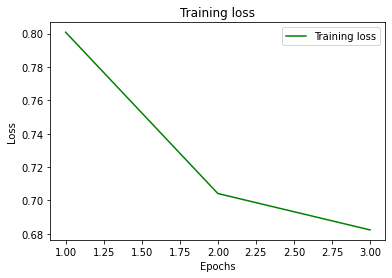

In [14]:
loss_train = history_bert.history['loss']
epochs = range(1,4)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

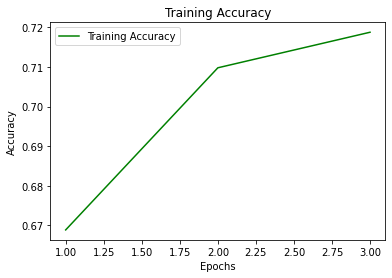

In [15]:
accuracy_train = history_bert.history['accuracy']
epochs = range(1,4)
plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
model_bert.save('MODEL-BERT.h5')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


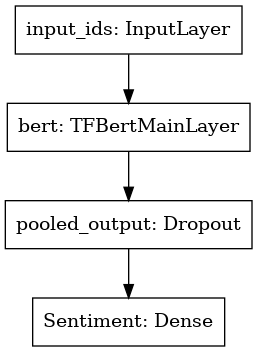

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model_bert, to_file='model.png')

In [18]:
model_eval = model_bert.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)

1220/1220 [==============================] - 92s 76ms/step - loss: 0.7376 - accuracy: 0.6891


In [19]:
y_val_predicted = model_bert.predict(
    x={'input_ids': x_val['input_ids']},
)

In [20]:
x_test = tokenizer(
          text=test['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [21]:
label_predicted_bert = model_bert.predict(
    x={'input_ids': x_test['input_ids']},
)

In [22]:
label_pred_bert=[np.argmax(i) for i in label_predicted_bert['Sentiment']]

In [23]:
label_pred_bert[:5]

[2, 2, 2, 3, 3]

In [24]:
sample_submission=pd.read_csv('../input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv')
sample_submission['Sentiment'] = label_pred_bert
sample_submission.to_csv("submission_BERT.csv", index=False, header=True)

**2) ROBERTA**

In [25]:
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig  

In [26]:
model_name = 'roberta-base'

# Max length of tokens
max_length = 45

# Load transformers config and set output_hidden_states to False
config = RobertaConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Roberta model
transformer_roberta_model = TFRobertaModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [27]:
# Load the MainLayer
roberta = transformer_roberta_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers RoBERTa model as a layer in a Keras model
roberta_model = roberta(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(train_data.Sentiment_value.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model_roberta = Model(inputs=inputs, outputs=outputs, name='RoBERTa_MultiClass')


In [28]:
model_roberta.summary()

Model: "RoBERTa_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 45)]              0         
_________________________________________________________________
roberta (TFRobertaMainLayer) TFBaseModelOutputWithPool 124645632 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Sentiment (Dense)            (None, 5)                 3845      
Total params: 124,649,477
Trainable params: 124,649,477
Non-trainable params: 0
_________________________________________________________________


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


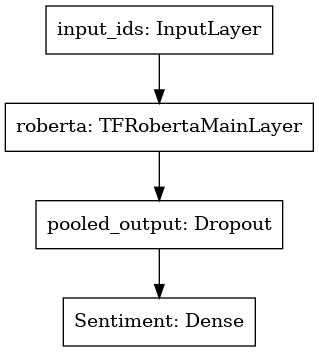

In [29]:
from keras.utils.vis_utils import plot_model
plot_model(model_roberta, to_file='model.png')

In [30]:
# Set an optimizer
optimizer = Adam(learning_rate=1e-05,epsilon=1e-06,decay=0.01)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model_roberta.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(train_data['Sentiment'])

# Tokenize the input 
x_train = tokenizer(
          text=train_data['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(test_data['Sentiment'])

x_val = tokenizer(
          text=test_data['Phrase'].to_list(),
          add_special_tokens=True,max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)


    

In [31]:
# Fit the model
history_roberta = model_roberta.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=64,
    epochs=3,
    verbose=1)

Epoch 1/3
1829/1829 [==============================] - 732s 393ms/step - loss: 0.9517 - accuracy: 0.6142 - val_loss: 0.8762 - val_accuracy: 0.6274
Epoch 2/3
1829/1829 [==============================] - 715s 391ms/step - loss: 0.8399 - accuracy: 0.6542 - val_loss: 0.8491 - val_accuracy: 0.6373
Epoch 3/3
1829/1829 [==============================] - 716s 392ms/step - loss: 0.8225 - accuracy: 0.6614 - val_loss: 0.8275 - val_accuracy: 0.6484


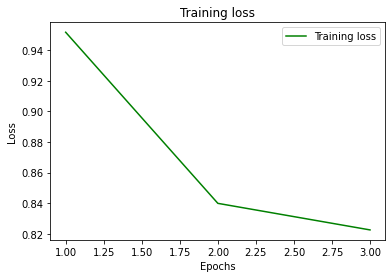

In [32]:
loss_train = history_roberta.history['loss']
epochs = range(1,4)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

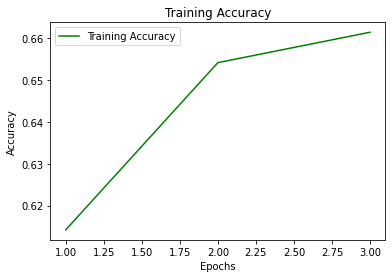

In [33]:
accuracy_train = history_roberta.history['accuracy']
epochs = range(1,4)
plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
model_roberta.save('MODEL-ROBERTA.h5')

In [35]:
model_eval_roberta = model_roberta.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)

1220/1220 [==============================] - 94s 77ms/step - loss: 0.8275 - accuracy: 0.6484


In [36]:
y_val_predicted = model_roberta.predict(
    x={'input_ids': x_val['input_ids']},
)

In [37]:
x_test = tokenizer(
          text=test['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)


In [38]:
label_predicted = model_roberta.predict(
    x={'input_ids': x_test['input_ids']},
)

In [39]:
label_pred_roberta=[np.argmax(i) for i in label_predicted['Sentiment']]

In [40]:
sample_submission=pd.read_csv('../input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv')
sample_submission['Sentiment'] = label_pred_roberta
sample_submission.to_csv("submission_ROBERTA.csv", index=False, header=True)